In [34]:
import pymongo
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

In [51]:
mongoclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = mongoclient['video_processing_67m_sma5-3']
db.name

'video_processing_67m_sma5-3'

In [52]:
collist = db.list_collection_names()
collist

['vpa', 'requests', 'usage']

In [53]:
vpa = pd.DataFrame(list(db['vpa'].find()))
vpa['time'] = pd.to_datetime(vpa['time'],unit='s').round('1s')
# vpa.head()

In [54]:
# convert cpu unit 'n' to 'm'
def convert_cpu(x):
    if x != 0:
        if x[-1] == 'n':
            return round(int(x[:-1])/1000000)
        elif x[-1] == 'm':
            return int(x[:-1])
    else:
        return 0
    
# convert memory unit 'k' and 'Ki' to 'Mi'
# 1k = 1000/1024 Ki = 1000/1024**2 Mi
def convert_mem(x):
    if x != 0:
        if x[-1] == 'k':
            return round(int(x[:-1])*1000/1024**2)
        elif x[-2:] == 'Ki':
            return round(int(x[:-2])/1024)
        elif x[-2:] == 'Mi':
            return int(x[:-2])
    else:
        return 0

In [55]:
record = {}
collist = ['usage', 'requests']
for col in collist:
    record[col] = pd.DataFrame(list(db[col].find()))
    # convert timestamp to time
    record[col]['time'] = pd.to_datetime(record[col]['time'],unit='s').round('1s')
    record[col]['cpu'] = record[col]['cpu'].apply(lambda x: convert_cpu(x))
    record[col]['cpu'] = record[col]['cpu'].fillna(0)
    record[col]['memory'] = record[col]['memory'].apply(lambda x: convert_mem(x))
# record['usage'].head()

In [56]:
vpa['target_cpu'] = vpa['target_cpu'].apply(lambda x: convert_cpu(x))
vpa['lowerBound_cpu'] = vpa['lowerBound_cpu'].apply(lambda x: convert_cpu(x))
vpa['upperBound_cpu'] = vpa['upperBound_cpu'].apply(lambda x: convert_cpu(x))

In [57]:
request = record['requests']
usage = record['usage']
request = request[request['pod_name'] == request.iloc[0]['pod_name']]
usage = usage[usage['pod_name'] == usage.iloc[1]['pod_name']]
# usage.head()

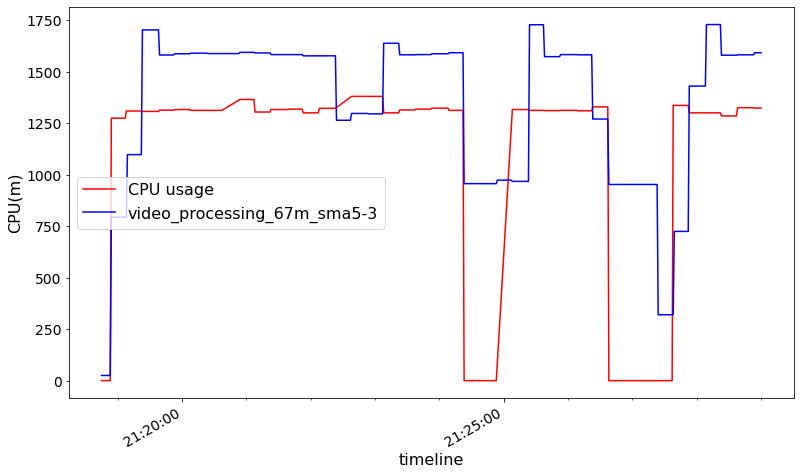

In [58]:
fig, ax = plt.subplots(1,1,figsize=(13,8),sharex=True,sharey=True)
# ax.scatter(request.time, request.cpu,marker='.',label='request')
ax.plot(usage.time, usage.cpu,label='CPU usage',color='r')
ax.plot(vpa.time, vpa.target_cpu,label=db.name,color='b')
ax.legend(fontsize=16)
ax.set_ylabel('CPU(m)', fontsize=16)
ax.set_xlabel('timeline', fontsize=16)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(mdates.MinuteLocator())
fig.autofmt_xdate() #rotate labels
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

In [10]:
def evaluate(usage, prediction):
    slack = list(map(operator.sub, prediction, usage))
    slack_total = 0
    insufficient_count = 0
    insufficient_total = 0
    for i in slack:
        if i < 0:
            insufficient_count += 1
            insufficient_total += abs(i)
        else:
            slack_total += i
    return slack_total/len(usage), insufficient_count/len(usage)*100, insufficient_total/len(usage)

In [11]:
db_name = []
db_name = evaluate(usage.cpu, vpa.target_cpu)
print("\t\tAvg. slack(m)\t Insufficient CPU(%)\t Avg. insufficient CPU(m)")
print(db.name, db_name[0], db_name[1], db_name[2])

		Avg. slack(m)	 Insufficient CPU(%)	 Avg. insufficient CPU(m)
image_rotate_sma5-3 186.08823529411765 22.058823529411764 111.61764705882354


In [12]:
# with open ('ycsb.txt','a') as f:
#     f.write(db.name+'\t'+str(db_name[0])+'\t'+str(db_name[1])+'\t'+str(db_name[2])+'\n')